<a href="https://colab.research.google.com/github/soham-wairkar/CE888/blob/main/LAB9/GAN_task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras import layers
import numpy as np

In [2]:
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# Transforms the input into a 16 × 16 128-channel feature map
s = layers.Dense(128 * 16 * 16)(generator_input)
s = layers.LeakyReLU()(s)
s = layers.Reshape((16, 16, 128))(s)

s = layers.Conv2D(256, 5, padding='same')(s)
s = layers.LeakyReLU()(s)

# Upsamples to 32 × 32
s = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(s)
s = layers.LeakyReLU()(s)

s = layers.Conv2D(256, 5, padding='same')(s)
s = layers.LeakyReLU()(s)
s = layers.Conv2D(256, 5, padding='same')(s)
s = layers.LeakyReLU()(s)

# Produces a 32 × 32 1-channel feature map (shape of a CIFAR10 image)
s = layers.Conv2D(channels, 7, activation='tanh', padding='same')(s)

# Instantiates the generator model, which maps the input of shape (latent_dim,) 
#into an image of shape (32, 32, 3)
generator = keras.models.Model(generator_input, s)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
dense (Dense)                (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 256)       104883

In [3]:
#gan disc network

discriminator_input = layers.Input(shape=(height, width, channels))

s = layers.Conv2D(128, 3)(discriminator_input)
s = layers.LeakyReLU()(s)
s = layers.Conv2D(128, 4, strides=2)(s)
s = layers.LeakyReLU()(s)
s = layers.Conv2D(128, 4, strides=2)(s)
s = layers.LeakyReLU()(s)
s = layers.Conv2D(128, 4, strides=2)(s)
s = layers.LeakyReLU()(s)
s = layers.Flatten()(s)

# One dropout layer: an important trick
s = layers.Dropout(0.4)(s)

# Classification layer
s = layers.Dense(1, activation='sigmoid')(s)

#Instantiates the discriminator model, which turns a (32, 32, 3) input into a binary 
#classification decision (fake/real)
discriminator = keras.models.Model(discriminator_input, s)
discriminator.summary()

# Uses gradient clipping (by value) in the optimizer and To stabilize training, 
# uses learning-rate decay
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008,clipvalue=1.0,decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer,loss='binary_crossentropy')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 6, 6, 128)         0   

In [5]:
#adversial network
# Sets discriminator weights to non-trainable (this will only apply to the gan model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [6]:
gan.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
model (Functional)           (None, 32, 32, 3)         6264579   
_________________________________________________________________
model_1 (Functional)         (None, 1)                 790913    
Total params: 7,055,492
Trainable params: 6,264,579
Non-trainable params: 790,913
_________________________________________________________________


In [7]:
import os
from keras.preprocessing import image
os.mkdir('GAN')

# Loads CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Selects frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

x_train = x_train.reshape(
    (x_train.shape[0],) +
    (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = '/content/GAN'# Specifies where you want to save generated images

start = 0
# Samples random points in the latent space
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

# Decodes them to fake images    
generated_images = generator.predict(random_latent_vectors)

# Combines them with real images 
stop = start + batch_size
real_images = x_train[start: stop]
combined_images = np.concatenate([generated_images, real_images])

labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
labels += 0.05 * np.random.random(labels.shape)

# Trains the discriminator
d_loss = discriminator.train_on_batch(combined_images, labels)

# Samples random points in the latent space
random_latent_vectors = np.random.normal(size=(batch_size,latent_dim))

# Assembles latent space labels that say “these are all real images” (it’s a lie!)
misleading_targets = np.zeros((batch_size, 1))

# Trains the generator (via the gan model, where the discriminator weights are frozen)
a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

start += batch_size
if start > len(x_train) - batch_size: 
    start = 0
    
if step % 100 == 0: 
    gan.save_weights('gan.h5')
    
print('discriminator loss:', d_loss)
print('adversarial loss:', a_loss)

img = image.array_to_img(generated_images[0] * 255., scale=False)
img.save(os.path.join(save_dir,
                      'generated_frog' + str(step) + '.png'))

img = image.array_to_img(real_images[0] * 255., scale=False)
img.save(os.path.join(save_dir,
                      'real_frog' + str(step) + '.png'))

170500096/170498071 [==============================] - 4s 0us/step
discriminator loss: 0.6945282220840454
adversarial loss: 0.6940848231315613


Text(0.5, 1.0, 'Real Frog')

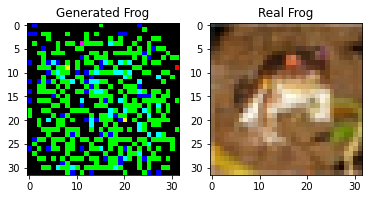

In [8]:
import matplotlib.pyplot as plt

generated_frog = plt.imread('./GAN/generated_frog9999.png')
real_frog = plt.imread('./GAN/real_frog9999.png')

plt.subplot(1,2,1)
plt.imshow(generated_frog)
plt.title('Generated Frog')

plt.subplot(1,2,2)
plt.imshow(real_frog)
plt.title('Real Frog')